<a id='Top'></a>

# Survival curves<a class='tocSkip'></a>

Survival curves from MultiSurv predictions compared to Kaplan-Meier estimations.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
import torch
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Make modules in "src" dir visible
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(os.path.join(project_dir, 'src'))

import dataset
from model import Model
import utils

matplotlib.style.use('multisurv.mplstyle')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>DataLoader</code></a></span></li><li><span><a href="#Model-predictions" data-toc-modified-id="Model-predictions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model predictions</a></span></li><li><span><a href="#Pan-cancer,-all-patient-survival-curve" data-toc-modified-id="Pan-cancer,-all-patient-survival-curve-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pan-cancer, all-patient survival curve</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Save to file</a></span></li></ul></li><li><span><a href="#High-vs.-low-risk-patient-survival" data-toc-modified-id="High-vs.-low-risk-patient-survival-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>High vs. low-risk patient survival</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Save to file</a></span></li></ul></li><li><span><a href="#Individual-cancer-types" data-toc-modified-id="Individual-cancer-types-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Individual cancer types</a></span><ul class="toc-item"><li><span><a href="#Selected-cancers" data-toc-modified-id="Selected-cancers-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Selected cancers</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Save to file</a></span></li></ul></li><li><span><a href="#All-others" data-toc-modified-id="All-others-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>All others</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Save to file</a></span></li></ul></li></ul></li><li><span><a href="#Individual-patients" data-toc-modified-id="Individual-patients-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Individual patients</a></span><ul class="toc-item"><li><span><a href="#One-patient-per-cancer-type" data-toc-modified-id="One-patient-per-cancer-type-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>One patient per cancer type</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Save to file</a></span></li></ul></li></ul></li></ul></div>

In [2]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
PLOT_SIZE = (4, 2.75)
PLOT_SIZE = (3.75, 2.5)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# `DataLoader`

In [4]:
cancers = ['TCGA-SARC', 'TCGA-LUSC', 'TCGA-OV']

labels = pd.read_csv('/app/data/labels.tsv', sep='\t')
print(labels.head(3))

# List of patients to exclude: patients with cancers that are not in the subset
exclude_cancers = list(labels.loc[labels['project_id'].isin(cancers), 'submitter_id'])
len(exclude_cancers)

   submitter_id project_id      time  event  group
0  TCGA-Z7-A8R6  TCGA-BRCA  8.920548      0  train
1  TCGA-C8-A1HE  TCGA-BRCA  1.027397      0  train
2  TCGA-A8-A07B  TCGA-BRCA  3.583562      0  train


1341

In [5]:
dataloaders = utils.get_dataloaders(
    data_location=DATA,
    labels_file='/app/data/labels.tsv',
    modalities=['clinical', 'mRNA'],
     exclude_patients=exclude_cancers,
    return_patient_id=True
)

Keeping 7734 patient(s) not in exclude list.
Keeping 968 patient(s) not in exclude list.
Keeping 968 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 7734
   val: 968
   test: 968

Batch size: 128


# Model predictions

Collect model predictions for all patients in the test dataset.

In [6]:
multisurv = Model(dataloaders=dataloaders, device=device)
multisurv.load_weights(os.path.join(MODELS, 'clinical_mRNA_lr0.005-no-SARC-LUSC-OV_no-pretrained-weights_epoch25_concord0.82.pth'))

Instantiating MultiSurv model...
Load model weights:
/mnt/data/multisurv_models/clinical_mRNA_lr0.005-no-SARC-LUSC-OV_no-pretrained-weights_epoch25_concord0.82.pth


/app/src/model.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


In [7]:
patient_dataset = dataloaders['test'].dataset

In [8]:
%%time

results = multisurv.predict_dataset(patient_dataset)
print()
print()

Analyzing patients
968/968

CPU times: user 22.8 s, sys: 2.73 s, total: 25.5 s
Wall time: 25.7 s


In [9]:
def predictions_to_pandas(data):
    labels = pd.read_csv('../data/labels.tsv', sep='\t')
#     clinical_data = pd.read_csv('../data/clinical_data.tsv', sep='\t',
#                                 na_values=['not reported', 'Not Reported'])

    predictions = np.stack([x[0] for x in data['patient_data'].values()])    
    # Add prediction 1 at time 0 (patients still alive)
    ones = np.ones((predictions.shape[0], 1))
    predictions = np.concatenate((ones, predictions), axis=1)
    
    predictions = pd.DataFrame(predictions, columns=[str(i) for i in range(predictions.shape[-1])])
    patient_ids = list(data['patient_data'].keys())
    predictions['submitter_id'] = patient_ids
    
    predictions = predictions.merge(labels.iloc[:, :-1])
    predictions.set_index('submitter_id', inplace=True)
    
    return predictions

In [10]:
predictions = predictions_to_pandas(data=results)

# Pan-cancer, all-patient survival curve

In [11]:
def get_KM_estimates(data, return_kmfitter=False):
    kmf = KaplanMeierFitter()
    kmf.fit(durations=data['time'].values,
            event_observed=data['event'].values)

    if return_kmfitter:
        return kmf

    x = kmf.survival_function_.index.values
    y = kmf.survival_function_
    
    return x, y

In [12]:
def plot_all_cancer_survival(data, cm, time_points, plot_size=PLOT_SIZE):
    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(1, 1, 1)
    
    x, y = get_KM_estimates(data)
    ax.plot(x, y, '--', color=cm['Kaplan-Meier'], label='Kaplan-Meier')

    mean_probabilities = data[[str(i) for i in range(len(time_points))]].mean(axis=0).values
    ax.plot(time_points[:22], mean_probabilities[:22], 'o-',
            color=cm['MultiSurv'], label='MultiSurv')

    ax.set_ylim(0, 1.1)
    ax.set_xlim(None, 22)
    ax.legend()
    ax.set_title('')
    ax.set(xlabel='Time (years)', ylabel='Survival probability')

    return fig

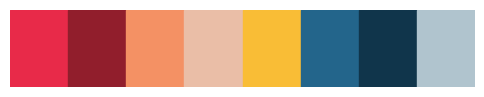

In [13]:
utils.plot.show_default_colors()

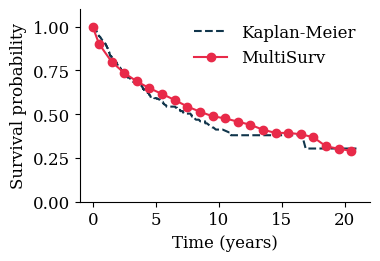

In [14]:
survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

selected_colors = {
    'MultiSurv': default_colors[0],
    'Kaplan-Meier': default_colors[-2]}
                                                          
fig = plot_all_cancer_survival(
    data=predictions,
    cm=selected_colors,
    time_points=survival_time_points)

## Save to file

In [16]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

# High vs. low-risk patient survival

Verify that Multisurv allows stratification of risk groups:

1. Compute median MultiSurv risk (of 1st predicted probability value);
1. Use median risk as threshold to split patients into low and high-risk groups;
1. Verify that this results in statistically significant (log-rank test) differences Kaplan-Meier survival estimates.

In [17]:
median_prob = predictions['1'].median()  ## column "0" is probability 1 added for time 0

risk_groups = {'Low-risk': predictions.loc[predictions['1'] > median_prob],
               'High-risk': predictions.loc[predictions['1'] <= median_prob]}

In [18]:
def custom_legend_for_group_survival_plot(colors, groups):
    # Color
    legend_elements = []
    for group in groups:
        legend_elements.append(matplotlib.patches.Patch(
            facecolor=colors[group], edgecolor=colors[group],
            linewidth=3, label=group))

    # Line style
    markers, line_styles = ['', 'o'], ['--', '-']
    for i, x in enumerate(['Kaplan-Meier', 'MultiSurv']):
        legend_elements.append(matplotlib.lines.Line2D(
            [0], [0], color='k', marker=markers[i], ls=line_styles[i], label=x))

    return legend_elements

In [19]:
def annotate_logrank(data, ax):
    kmf = {}
    
    for group in data:
        kmf[group] = get_KM_estimates(data[group], return_kmfitter=True)

    lr_test = logrank_test(durations_A=kmf['Low-risk'].durations,
                           durations_B=kmf['High-risk'].durations,
                           event_observed_A=kmf['Low-risk'].event_observed,
                           event_observed_B=kmf['High-risk'].event_observed)

    ax.text(12, 0.9, 'p', style='italic')
#     ax.text(13.5, 0.9, f'= {lr_test.p_value:.1e}')
    base, exp = f'{lr_test.p_value:.1e}'.split('e')
    txt = r'= ${0:}^{{{1:}}}$'.format(base, exp)
    ax.text(13.5, 0.9, txt)
    
    
    return ax

In [20]:
def plot_risk_group_survival(data, group_cm, time_points, annotation_func=None,
                             plot_size=PLOT_SIZE):
    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(1, 1, 1)

    for group in data:
        x, y = get_KM_estimates(data[group])
        ax.plot(x, y, '--', color=group_cm[group], label=group)
        
        mean_probabilities = data[group][[str(i) for i in range(len(time_points))]].mean(axis=0).values
        ax.plot(time_points[:22], mean_probabilities[:22], 'o-',
                color=group_cm[group], label=group)

    ax.set_ylim(0, 1.1)
    ax.set_xlim(None, 22)
    legend_elements = custom_legend_for_group_survival_plot(
        colors=group_cm, groups=group_cm.keys())
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('')
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Survival probability')
    
    if annotation_func is not None:
        ax = annotation_func(data, ax)

    return fig

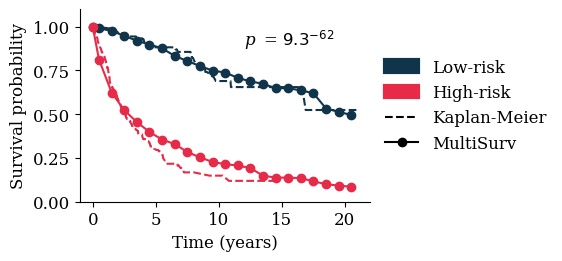

In [21]:
survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

group_colors = {
    'Low-risk': default_colors[-2],
    'High-risk': default_colors[0]}
                                                          
fig = plot_risk_group_survival(
    data=risk_groups,
    group_cm=group_colors,
    time_points=survival_time_points,
    annotation_func=annotate_logrank)

## Save to file

# Individual cancer types

## Selected cancers

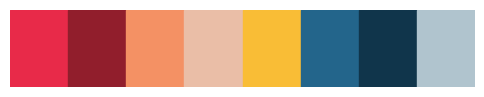

In [22]:
utils.plot.show_default_colors()

In [23]:
def plot_selected_cancer_type_survival(data, cancer_type_cm, time_points, plot_size=PLOT_SIZE):
    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(1, 1, 1)

    for cancer_type in cancer_type_cm:
        cancer_data = data[data['project_id'] == 'TCGA-' + cancer_type]
        x, y = get_KM_estimates(cancer_data)
        ax.plot(x, y, '--', color=cancer_type_cm[cancer_type], label=cancer_type)
        
        mean_probabilities = cancer_data[[str(i) for i in range(len(time_points))]].mean(axis=0).values
        ax.plot(time_points[:22], mean_probabilities[:22], 'o-',
                color=cancer_type_cm[cancer_type], label=cancer_type)

    ax.set_ylim(0, 1.1)
    ax.set_xlim(None, 22)
    legend_elements = custom_legend_for_group_survival_plot(
        colors=cancer_type_cm, groups=cancer_type_cm.keys())
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('')
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Survival probability')

    return fig

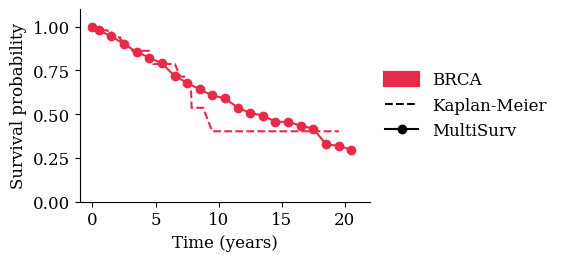

In [25]:
survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

cancer_type_colors = {
    'BRCA': default_colors[0]}

fig = plot_selected_cancer_type_survival(
    data=predictions,
    cancer_type_cm=cancer_type_colors,
    time_points=survival_time_points)

### Save to file

## All others

In [24]:
all_others = [cancer for cancer in pd.read_csv('/app/data/labels.tsv', sep='\t').project_id.unique()
              if not cancer in cancer_type_colors]
all_others = sorted(all_others)

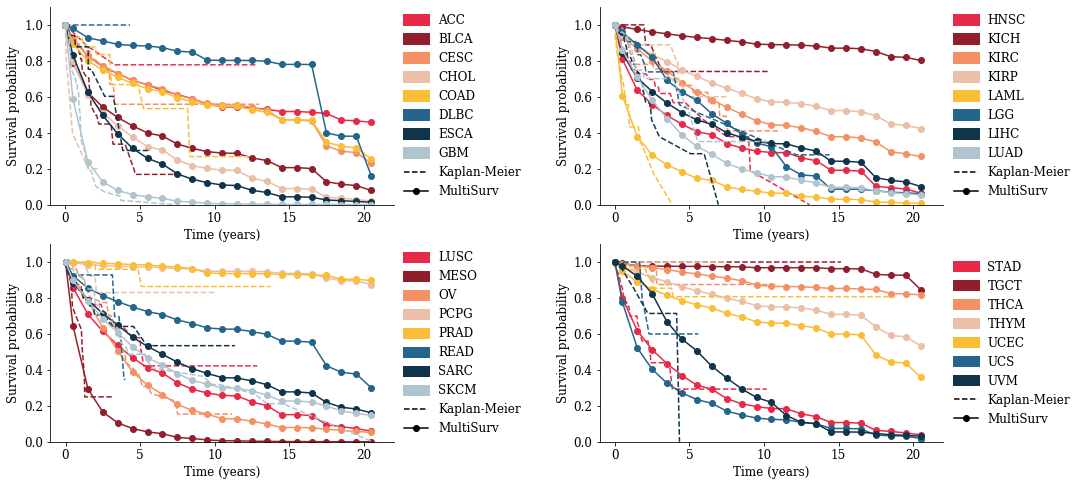

In [25]:
survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

fig, axs = plt.subplots(2, 2, figsize=(16, 8))
fig.subplots_adjust(hspace = .2, wspace=.6)
axs = axs.ravel()

start = 0

for i in range(4):
    axs[i].set_prop_cycle(cycler('color', sum([[color] * 2 for color in default_colors], [])))
#     axs[i].set_prop_cycle(cycler('color', default_colors))
    end = 8 * (i + 1)
    
    # Plot patient subset for current iteration's cancer types
    cancer_types = all_others[start:end]
    start = end  # Update start index
    
    for cancer_type in cancer_types:
        cancer_data = predictions[predictions['project_id'] == cancer_type]
        x, y = get_KM_estimates(cancer_data)
        axs[i].plot(x, y, '--', label=cancer_type)
        
        mean_probabilities = cancer_data[[str(i) for i in range(len(survival_time_points))]].mean(axis=0).values
        axs[i].plot(survival_time_points[:22], mean_probabilities[:22], 'o-', label=cancer_type)

    axs[i].set_ylim(0, 1.1)
    axs[i].set_xlim(None, 22)
    group_color = {cancer_type: default_colors[i]
                   for i, cancer_type in enumerate(cancer_types)}
    legend_elements = custom_legend_for_group_survival_plot(
        colors=group_color, groups=cancer_types)
    axs[i].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    axs[i].set_title('')
    axs[i].set_xlabel('Time (years)')
    axs[i].set_ylabel('Survival probability')

### Save to file

# Individual patients

## One patient per cancer type

In [26]:
# Select patients by follow-up time
def sorted_follow_up_times(cancer_type, idx=0, remove_censored=False):
    data = predictions[predictions.project_id == cancer_type]
    if remove_censored:
        data = data[data.event == 0]
    followup_time = data.sort_values(by=['time'], ascending=False)['time'][idx]
    event_indicator = data.sort_values(by=['time'], ascending=False)['event'][idx]
    patient_id = data.sort_values(by=['time'], ascending=False).index[idx]

    return patient_id, followup_time, event_indicator

In [28]:
# PRAD patient with long follow up
sorted_follow_up_times('PRAD', idx=1)

('TCGA-HI-7169', 7.353424657534248, 0)

In [39]:
# KIRC patient with long follow up
sorted_follow_up_times('KIRC', idx=3)

('TCGA-B0-5691', 9.4, 0)

In [40]:
# OV patient
sorted_follow_up_times('OV', idx=6)

('TCGA-29-1762', 7.216438356164383, 1)

In [48]:
# OV patient
sorted_follow_up_times('GBM', idx=5)

('TCGA-19-1390', 2.115068493150685, 1)

In [49]:
selected_patients = {'PRAD': 'TCGA-HI-7169',
                     'KIRC': 'TCGA-B0-5691',
                     'OV': 'TCGA-29-1762',
                     'GBM':  'TCGA-19-1390'}

__Patient details:__

* __TCGA-HI-7169:__ 55 year-old white male diagnosed with Prostate Adenocarcinoma (__PRAD__); __alive__ at last follow up 2,684 days after diagnosis;
* __TCGA-B0-5691:__ 66 year-old white female diagnosed with Kidney Renal Clear Cell Carcinoma (__KIRC__); __alive__ at last follow up 3,431 days after diagnosis;
* __TCGA-29-1762:__ 59 year-old white female diagnosed with Ovarian Serous Cystadenocarcinoma (__OV__); __dead__ 2,606 days after diagnosis.
* __TCGA-19-1390:__ 63 year-old white female diagnosed with Glioblastoma Multiforme (__GBM__); __dead__ 772 days after diagnosis.

(accessed by entering patient ID in the search box at [GDC Data Portal](https://portal.gdc.cancer.gov/))

In [50]:
def custom_legend_for_patient_survival_plot(colors, groups):
    # Color
    legend_elements = []
    for group in groups:
        legend_elements.append(matplotlib.patches.Patch(
            facecolor=colors[group], edgecolor=colors[group],
            linewidth=3, label=group))
    
    # Line style
    markers, alphas = ['o', ''], [1, 0.15]
    for i, x in enumerate(['Selected patient', 'All other patients']):
        legend_elements.append(matplotlib.lines.Line2D(
            [0], [0], color='k', marker=markers[i], alpha=alphas[i], label=x))   

    return legend_elements

In [51]:
def annotate_follow_up_time(ax, annotation_map, cancer_type_cm):
    text = annotation_map['text']
    xy = (annotation_map['time_point'],
          annotation_map['probability'])
    nudge = annotation_map['nudge']
    text_coords = (annotation_map['time_point'] + nudge[0],
                   annotation_map['probability'] + nudge[1])
    c = cancer_type_cm[annotation_map['cancer_type']]

    ax.annotate(text, xy=xy, xytext=text_coords,
                color=c,
                bbox=dict(boxstyle='round,pad=0.1', fc='w', ec='w', alpha=0.5),
                arrowprops=dict(arrowstyle='-', color=c))

    return ax

In [52]:
def plot_selected_patient_survival(data, selected_patients, cancer_type_cm, time_points,
                                   follow_up_annotations=None, plot_size=PLOT_SIZE):
    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(1, 1, 1)

    for cancer_type in cancer_type_cm:
        cancer_data = data[data['project_id'] == cancer_type]
        selected_patient = selected_patients[cancer_type]
        
        for patient in cancer_data.index:
            probabilities = cancer_data.loc[patient][[str(i) for i in range(len(time_points))]].values
            
            if patient != selected_patient:
                ax.plot(time_points[:22], probabilities[:22],
                        linestyle='-', color=cancer_type_cm[cancer_type],
                        alpha=0.1, label=cancer_type + ' patients')
            else:
                ax.plot(time_points[:22], probabilities[:22],
                        marker='o', color=cancer_type_cm[cancer_type],
                        label=selected_patient)
                
    if follow_up_annotations is not None:
        # Draw lines at end of follow-up time
        for patient in follow_up_annotations:
            ax = annotate_follow_up_time(ax, follow_up_annotations[patient], cancer_type_cm)

    ax.set_ylim(0, 1.1)
    ax.set_xlim(None, 22)
    legend_elements = custom_legend_for_patient_survival_plot(
        colors=cancer_type_cm, groups=cancer_type_cm.keys())
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('')
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Survival probability')

    return fig

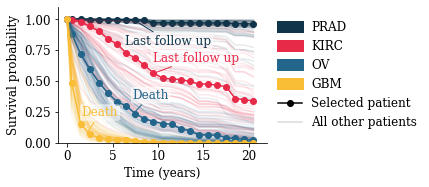

In [53]:
survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

cancer_type_colors = {
    'PRAD': default_colors[6],
#     'BRCA': default_colors[0],
    'KIRC': default_colors[0],
    'OV': default_colors[5],
    'GBM': default_colors[4],
}

nudges = {selected_patients['PRAD']: (-1, -0.2),
#           selected_patients['BRCA']: (-6, -0.275),
          selected_patients['KIRC']: (0, 0.1),
          selected_patients['OV']: (0, 0.125),
          selected_patients['GBM']: (-0.5, 0.15)}
annotation_text = {selected_patients['PRAD']: 'Last follow up',
#                    selected_patients['BRCA']: 'Last follow up',
                   selected_patients['KIRC']: 'Last follow up',
                   selected_patients['OV']: 'Death',
                   selected_patients['GBM']: 'Death'}

follow_up_annotation_map = {}

for cancer_type in selected_patients:
    patient = selected_patients[cancer_type]
    follow_up_annotation_map[patient] = {'cancer_type': cancer_type,
                                         'time_point': predictions.loc[patient]['time'],
                                         'probability': multisurv.predict(
                                             input_data=patient_dataset.get_patient_data(patient)[0],
                                             prediction_year=predictions.loc[patient]['time'])[1],
                                         'nudge': nudges[patient],
                                         'text': annotation_text[patient]}
    
fig = plot_selected_patient_survival(
    data=predictions,
    selected_patients=selected_patients,
    cancer_type_cm=cancer_type_colors,
    time_points=survival_time_points,
    follow_up_annotations=follow_up_annotation_map)

### Save to file

# Watermark<a class='tocSkip'></a>

In [54]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

torch      1.4.0
numpy      1.18.1
matplotlib 3.1.2
pandas     1.0.1

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)